In [6]:
from osgeo import gdal, osr
import os, struct
import numpy as np
import subprocess
import geopandas as gpd
import multiprocessing
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rioxarray
from scipy.spatial import cKDTree
from shapely.geometry import Point

In [7]:
# function to project GRACED data to ESRI:54009: START
def crs_transform(graced_path, out_crs = "ESRI:54009"):
    """
    Transform GRACED data to ESRI:54009
    Input:
        graced: GRACED dataframe
        out_crs: output crs
    Output:
        graced: GRACED dataframe with geometry in ESRI:54009
    """
    graced = gpd.read_parquet(graced_path)
    graced.set_geometry('geometry', inplace=True)
    graced = graced.to_crs('ESRI:54009')
    # pull out the latitude and longitude from the gemoetry column
    graced['latitude_54009'] = graced.geometry.y
    graced['longitude_54009'] = graced.geometry.x
    # make the latitude_54009 and longitude_54009 columns integers
    graced['latitude_54009'] = graced['latitude_54009'].astype(int)
    graced['longitude_54009'] = graced['longitude_54009'].astype(int)

    return graced


In [30]:
edgar_path = '/shared/data/building-emissions/comparisons/EDGAR/2020v8/edgar_2020_with_polygons.parquet'
edgar= crs_transform(edgar_path, out_crs = "ESRI:54009")


In [31]:
# rename column edgar_emission_2020(tons_CO2) to total_emission
edgar.rename(columns = {'edgar_emission_2020(tons_CO2)':'total_emission'}, inplace = True)
# rename lat, lon columns to latitude, longitude
edgar.rename(columns = {'lat':'latitude', 'lon':'longitude'}, inplace = True)
edgar

,latitude,longitude,total_emission,lon_center,lat_center,geometry,polygons,points,latitude_54009,longitude_54009
0,62.6,55.5,8.178070,55.55,62.65,POINT (3413137.385 7126161.800),"POLYGON ((55.60000 62.70000, 55.60000 62.60000...",POINT (55.55000 62.65000),7126161,3413137
1,56.8,33.0,152.594000,33.05,56.85,POINT (2269246.245 6570780.772),"POLYGON ((33.10000 56.90000, 33.10000 56.80000...",POINT (33.05000 56.85000),6570780,2269246
2,55.2,78.6,135.991000,78.65,55.25,POINT (5544334.213 6411658.500),"POLYGON ((78.70000 55.30000, 78.70000 55.20000...",POINT (78.65000 55.25000),6411658,5544334
3,54.9,86.5,3.067990,86.55,54.95,POINT (6130350.716 6381557.382),"POLYGON ((86.60000 55.00000, 86.60000 54.90000...",POINT (86.55000 54.95000),6381557,6130350
4,43.9,60.0,0.366388,60.05,43.95,POINT (4905363.803 5225949.545),"POLYGON ((60.10000 44.00000, 60.10000 43.90000...",POINT (60.05000 43.95000),5225949,4905363
...,...,...,...,...,...,...,...,...,...,...
881540,29.9,9.9,0.168747,9.95,29.95,POINT (912510.164 3638000.198),"POLYGON ((10.00000 30.00000, 10.00000 29.90000...",POINT (9.95000 29.95000),3638000,912510
881541,-22.6,-65.8,116.542000,-65.75,-22.55,POINT (-6273468.771 -2760483.565),"POLYGON ((-65.70000 -22.50000, -65.70000 -22.6...",POINT (-65.75000 -22.55000),-2760483,-6273468
881542,-38.4,-63.9,24.750800,-63.85,-38.35,POINT (-5502796.195 -4604148.312),"POLYGON ((-63.80000 -38.30000, -63.80000 -38.4...",POINT (-63.85000 -38.35000),-4604148,-5502796
881543,-26.3,-58.5,45.024400,-58.45,-26.25,POINT (-5476520.361 -3201894.329),"POLYGON ((-58.40000 -26.20000, -58.40000 -26.3...",POINT (-58.45000 -26.25000),-3201894,-5476520


In [34]:
# read HSL finer resolution data
area_path = '/shared/data/ghsl_data/2020/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_1000_V1_0/GHS_BUILT_S_E2020_GLOBE_R2023A_54009_1000_V1_0.tif'
total_floor_area_path = '/shared/data/building-emissions/data/ghsl/building_floor_area_2020.parquet'
rds = rioxarray.open_rasterio(area_path)
rds.name = "building_footprint_area"
ghs = rds.squeeze().to_dataframe().reset_index()

ghs_floor = pd.read_parquet(total_floor_area_path)


In [37]:
ghs = ghs[['y', 'x', 'building_footprint_area']]

In [ ]:
ghs['building_floor_area'] = ghs_floor['building_floor_area']

In [41]:
# replace water body and keep track of water body
ghs['non_water_body'] = np.where(ghs['building_footprint_area'] == 4294967295, 0, 1)
ghs['building_footprint_area'] = ghs['building_footprint_area'].replace(4294967295, 0) # replace water body 
ghs['building_floor_area'] = ghs['building_floor_area'].replace(4294967295, 0) # replace water body

### chunking

In [49]:

# function to chunk grid and gdf into smaller dataframes: START
def chunk_grid_multiprocess(
    i,chunk_size,k,chunk_gdf_dir):
    """
    Child function to chunk grid and gdf into smaller dataframes, save to destination directory
    Input:
        i: starting row number
        chunk_size: number of rows in each chunk
        k: chunk number
        dest_dir_chunked_grid: directory to save grid chunks
        dest_dir_chunked_gdf: directory to save gdf chunks
        dest_dir_chunked_full_gdf: directory to save full gdf chunks
    Output:
        None
    """
    if k == 9999:
        ghs_gdf_chunk = ghs_gdf.iloc[i:]
    else:
        ghs_gdf_chunk = ghs_gdf.iloc[i : i + chunk_size]
    ghs_gdf_chunk.to_parquet(
        os.path.join(chunk_gdf_dir, f"ghs_gdf_chunk_{k}.parquet"), index = False)

    pass


def child_initialize_grid(_ghs_gdf):
    """
    """
    global ghs_gdf
    ghs_gdf = _ghs_gdf
    pass


def chunk_grid_gdf(
    ghs_gdf,
    n_chunks,
    chunk_gdf_dir,
):
    """
    Multiprocessing chunking grid and gdf into smaller dataframes, save to destination directory
    Input:
    Output:
        None
    """
    print("Start chunking grid and gdf into smaller dataframes")
    # use multiprocessing to speed up
    num_cores = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(
        processes=num_cores,
        initializer=child_initialize_grid,
        initargs=(ghs_gdf,))

    chunk_size = len(ghs_gdf) // n_chunks

    k = 0
    for i in range(0, len(ghs_gdf), chunk_size):
        pool.apply_async(chunk_grid_multiprocess,args=(i,chunk_size,k,chunk_gdf_dir))

        k += 1
    pool.close()
    pool.join()
    
    print("Chunking grid and gdf into smaller dataframes done")
    pass
# function to chunk grid and gdf into smaller dataframes: END


In [44]:
chunk_gdf_dir = '/shared/data/building-emissions/data/processing_file_edgar_graced/edgar_building_area/chunk_gdfs'
# chunk grid and gdf into smaller dataframes
chunk_grid_gdf(ghs,10000,chunk_gdf_dir)


Start chunking grid and gdf into smaller dataframes


Chunking grid and gdf into smaller dataframes done


In [46]:
del ghs

### Matching

In [57]:
# function to re-allocate emissions to grid cells: START

def nearest_point(chunk_path, chunk_gdf_graced_dir, i):
    # print(f"Processing chunk: {chunk_path}")
    ghs_chunk = pd.read_parquet(chunk_path)
    ghs_chunk['original_index'] = 0
    # ghs_chunk['graced_polygons'] = None
    ghs_chunk['total_emission'] = None
    ghs_chunk['lat'] = None
    ghs_chunk['lon'] = None
    ghs_chunk['lat_original'] = None
    ghs_chunk['lon_original'] = None
    for j in range(len(ghs_chunk)):
        given_point = (ghs_chunk.iloc[j].y, ghs_chunk.iloc[j].x)
        npi = kdtree.query(given_point)[1]
        graced_row = graced.iloc[npi]
        ghs_chunk.loc[j, ['original_index', 'total_emission', 'lat', 'lon', 'lat_original', 'lon_original']] = \
            npi, graced_row['total_emission'], graced_row['latitude_54009'], graced_row['longitude_54009'], graced_row['lat_center'], graced_row['lon_center']
    ghs_chunk.to_parquet(os.path.join(chunk_gdf_graced_dir, f'reallocated_chunk_{i}.parquet'), index = False)

        
def child_initialize_tree(_kdtree, _graced):
    """
    """
    global kdtree, graced
    kdtree = _kdtree
    graced = _graced
    pass


def grid_match_graced(graced, chunk_gdf_dir, chunk_gdf_graced_dir):
    """
    Multiprocessing re-allocate emissions to grid cells
    Input:
        graced: graced dataframe
        chunk_gdf_dir: directory to load gdf chunks
        chunk_gdf_graced_dir: directory to save gdf chunks with re-allocated emissions
    Output:
        None
    """
    print("Start re-allocate emissions to grid cells")
    graced_points = list(zip(graced.latitude_54009, graced.longitude_54009))
    kdtree = cKDTree(graced_points)

    num_cores = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(
        processes=num_cores,
        initializer=child_initialize_tree,
        initargs=(kdtree,graced,))

    for i in range(10000):
        chunk_path = os.path.join(chunk_gdf_dir, f'ghs_gdf_chunk_{i}.parquet')
        pool.apply_async(nearest_point,args=(chunk_path, chunk_gdf_graced_dir, i))
    pool.close()
    pool.join()
    print("Re-allocate emissions to grid cells done")
    pass
# function to re-allocate emissions to grid cells: END

In [59]:
# re-allocate emissions to grid cells
chunk_gdf_dir = '/shared/data/building-emissions/data/processing_file_edgar_graced/edgar_building_area/chunk_gdfs'
chunk_gdf_edgar_dir = "/shared/data/building-emissions/data/processing_file_edgar_graced/edgar_building_area/chunk_gdf_edgar"
grid_match_graced(edgar, chunk_gdf_dir, chunk_gdf_edgar_dir) # 205 mins

Start re-allocate emissions to grid cells
Re-allocate emissions to grid cells done


In [ ]:
# pd.read_parquet(os.path.join(chunk_gdf_edgar_dir, f'reallocated_chunk_{9999}.parquet'))

## Concat

In [61]:
# function to concat the re-allocated emission chunk: START
def subprocess_concat(chunk_path, graced_grid_list):
    graced_chunk = pd.read_parquet(chunk_path)
    # graced_chunk = gpd.GeoDataFrame(graced_chunk, geometry= gpd.points_from_xy(graced_chunk.x, graced_chunk.y), crs = 'ESRI:54009')
    graced_grid_list.append(graced_chunk)


def generate_data(graced_grid_list):
    for item in graced_grid_list:
        yield item

def concat_gdf_graced_chunk(chunk_gdf_graced_dir, concat_gdf_graced_path):
    """
    Multiprocessing concat the re-allocated emission chunk
    Input:
        chunk_gdf_graced_dir: directory to load gdf chunks with re-allocated emissions
        concat_gdf_graced_path: path to save concatenated gdf with re-allocated GRACE emissions
    Output:
        graced_fine_gdf: concatenated gdf with re-allocated emissions
    """
    print('start to concat')
    num_cores = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(
    processes=num_cores)
    manager = multiprocessing.Manager()
    graced_grid_list = manager.list()
    for i in range(10000):
        chunk_path = os.path.join(chunk_gdf_graced_dir, f'reallocated_chunk_{i}.parquet')
        pool.apply_async(subprocess_concat, args = (chunk_path, graced_grid_list))
    
    pool.close()
    pool.join()
    print('processing done, start to concat')
    generator = generate_data(graced_grid_list)
    del graced_grid_list
    # graced_fine_gdf = gpd.GeoDataFrame(pd.concat(generator, ignore_index=True, axis= 0))
    graced_fine_gdf = pd.concat(generator, ignore_index=True, axis= 0)
    print('concat done, save to file')
    # save graced_grid
    graced_fine_gdf.to_parquet(concat_gdf_graced_path)
    print('save concat file done')
    return graced_fine_gdf
# function to concat the re-allocated emission chunk: END

In [62]:
# concat the re-allocated emission chunk
chunk_gdf_edgar_dir = "/shared/data/building-emissions/data/processing_file_edgar_graced/edgar_building_area/chunk_gdf_edgar"
concat_gdf_edgar_path = "/shared/data/building-emissions/data/processing_file_edgar_graced/edgar_building_area/edgar_fine_gdf.parquet"
edgar_fine_gdf = concat_gdf_graced_chunk(chunk_gdf_edgar_dir, concat_gdf_edgar_path) # 30 mins

start to concat
processing done, start to concat
concat done, save to file
save concat file done


## Emission

- path
[Footprint area]
    * (non-compressed) ```/shared/data/building-emissions/data/processing_file_edgar_graced/reallocated_edgar_on_building_area_54009.tif```
    * (compressed) ```/shared/data/building-emissions/data/processing_file_edgar_graced/reallocated_edgar_on_building_area_54009_compressed.tif```
[Total Floor Area]
    * (non-compressed) /shared/data/building-emissions/data/processing_file_edgar_graced/reallocated_edgar_on_building_floor_area_54009.tif
    * (compressed) /shared/data/building-emissions/data/processing_file_edgar_graced/reallocated_edgar_on_building_floor_area_54009_compressed.tif
- Statistics
    * Total Emissions from Original Edgar:            3655946744.8610306
    * Re-allocated Emissions on non-0-building grids: 3652622425.9809456
    * Re-allocated Emissions on 0-building grids: 0.09%

In [77]:
# get proportional emissions
re_allocated_proportinal_edgar_path = "/shared/data/building-emissions/data/processing_file_edgar_graced/edgar_building_area/reallocated_edgar_54009.parquet"
# edgar_fine_gdf = get_proportional_emission(edgar_fine_gdf, re_allocated_proportinal_edgar_path) # 3 mins

In [64]:

print('start to get proportional emissions')
# reanme data colum to area to avoid confusion
# edgar_fine_gdf.rename(columns={'data': 'area'}, inplace = True)

# get building area* graced emission
edgar_fine_gdf['footprint_area_emission'] = edgar_fine_gdf['building_footprint_area'] * edgar_fine_gdf['total_emission']
edgar_fine_gdf['floor_area_emission'] = edgar_fine_gdf['building_floor_area'] * edgar_fine_gdf['total_emission']
# group by graced index and get sum area correspoding to graced index
edgar_fine_gdf['footprint_sum_area'] = edgar_fine_gdf.groupby('original_index')['building_footprint_area'].transform('sum') 
edgar_fine_gdf['floor_sum_area'] = edgar_fine_gdf.groupby('original_index')['building_floor_area'].transform('sum')
# get proportional emission: area* total_emission/sum_area, avoid zero division
edgar_fine_gdf['footprint_area_emission_portion'] = np.where(
    edgar_fine_gdf['footprint_sum_area'] != 0,
    edgar_fine_gdf['footprint_area_emission'] / edgar_fine_gdf['footprint_sum_area'],0)
edgar_fine_gdf['floor_area_emission_portion'] = np.where(
    edgar_fine_gdf['floor_sum_area'] != 0,
    edgar_fine_gdf['floor_area_emission'] / edgar_fine_gdf['floor_sum_area'],0)



start to get proportional emissions


In [65]:
edgar_fine_gdf

,y,x,building_footprint_area,building_floor_area,non_water_body,original_index,total_emission,lat,lon,lat_original,lon_original,footprint_area_emission,floor_area_emission,footprint_sum_area,floor_sum_area,footprint_area_emission_portion,floor_area_emission_portion
0,8996500.0,3607500.0,0,0.0,0,661850,0.010705,8470698,3607780,79.15,104.75,0.0,0.0,0,0.0,0.0,0.0
1,8996500.0,3608500.0,0,0.0,0,661850,0.010705,8470698,3607780,79.15,104.75,0.0,0.0,0,0.0,0.0,0.0
2,8996500.0,3609500.0,0,0.0,0,661850,0.010705,8470698,3607780,79.15,104.75,0.0,0.0,0,0.0,0.0,0.0
3,8996500.0,3610500.0,0,0.0,0,794679,0.011456,8470698,3611224,79.15,104.85,0.0,0.0,0,0.0,0.0,0.0
4,8996500.0,3611500.0,0,0.0,0,794679,0.011456,8470698,3611224,79.15,104.85,0.0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649475995,-8999500.0,18036500.0,0,0.0,0,461626,0.724045,-4626689,15361374,-38.55,178.55,0.0,0.0,0,0.0,0.0,0.0
649475996,-8999500.0,18037500.0,0,0.0,0,461626,0.724045,-4626689,15361374,-38.55,178.55,0.0,0.0,0,0.0,0.0,0.0
649475997,-8999500.0,18038500.0,0,0.0,0,461626,0.724045,-4626689,15361374,-38.55,178.55,0.0,0.0,0,0.0,0.0,0.0
649475998,-8999500.0,18039500.0,0,0.0,0,461626,0.724045,-4626689,15361374,-38.55,178.55,0.0,0.0,0,0.0,0.0,0.0


In [69]:
print(f'sum of total emission: {edgar['total_emission'].sum()}') # sum of total emission is 3634740375.188317
print(f'sum of footprint emission: {edgar_fine_gdf.footprint_area_emission_portion.sum()}') # sum of proportional emission that is not on 0-building area is 3634740375.188317
print(f'sum of floor emission: {edgar_fine_gdf.floor_area_emission_portion.sum()}') # sum of proportional emission that is not on 0-building area is 3634740375.188317

sum of total emission: 3655946744.8610306
sum of footprint emission: 3652622425.9809456
sum of floor emission: 3652622425.980978


In [72]:
print('Emissions on 0-bulding area is', (edgar['total_emission'].sum() - edgar_fine_gdf.footprint_area_emission_portion.sum()) / edgar['total_emission'].sum()*100, '% of total emissions')

Emissions on 0-bulding area is 0.09092908382097767 % of total emissions


In [ ]:

# get new proportional emission to equally distribute emission if sum_area == 0
# add a column "count_non_water_body" to count the number of non-number body in each original_index
edgar_fine_gdf['count_non_water_body'] =edgar_fine_gdf.groupby('original_index')['non_water_body'].transform('sum')

# calculate the area_emission_portion_w_0_distribution: if non_water_body == 1, then area_emission_portion * (1/count_non_water_body)
edgar_fine_gdf['footprint_area_emission_portion_w_0_distribution'] = np.where(
    (edgar_fine_gdf['non_water_body'] == 1) & (edgar_fine_gdf['footprint_sum_area'] == 0),
    edgar_fine_gdf['total_emission'] /edgar_fine_gdf['count_non_water_body'], edgar_fine_gdf['footprint_area_emission_portion'])
edgar_fine_gdf['floor_area_emission_portion_w_0_distribution'] = np.where(
    (edgar_fine_gdf['non_water_body'] == 1) & (edgar_fine_gdf['floor_sum_area'] == 0),
    edgar_fine_gdf['total_emission'] /edgar_fine_gdf['count_non_water_body'], edgar_fine_gdf['floor_area_emission_portion'])

# redistribute the emission to all-water-body grid cells
# add a colum count_grids to count the number of grids in each original_index
edgar_fine_gdf['count_grids'] = edgar_fine_gdf.groupby('original_index')['original_index'].transform('count')
# redistribute emissions by count_grids where total_emission != 0 and sum_area == 0 and count_non_water_body ==0
edgar_fine_gdf['footprint_area_emission_portion_w_0_distribution'] =\
    np.where((edgar_fine_gdf['total_emission'] != 0) & (edgar_fine_gdf['footprint_sum_area'] == 0) & (edgar_fine_gdf['count_non_water_body'] == 0),\
                edgar_fine_gdf['total_emission'] / edgar_fine_gdf['count_grids'], edgar_fine_gdf['footprint_area_emission_portion_w_0_distribution'])
edgar_fine_gdf['floor_area_emission_portion_w_0_distribution'] =\
    np.where((edgar_fine_gdf['total_emission'] != 0) & (edgar_fine_gdf['floor_sum_area'] == 0) & (edgar_fine_gdf['count_non_water_body'] == 0),\
                edgar_fine_gdf['total_emission'] / edgar_fine_gdf['count_grids'], edgar_fine_gdf['floor_area_emission_portion_w_0_distribution'])
    
# # edgar_fine_gdf.to_parquet(re_allocated_proportinal_edgar_path)
# print('get proportional emissions done')
# function to get proportional emissions: END


In [76]:
edgar_fine_gdf.floor_area_emission_portion_w_0_distribution.sum()

3655946744.8610044

In [78]:
edgar_fine_gdf.to_parquet(re_allocated_proportinal_edgar_path)


## Tiff

In [82]:
import xarray as xr
def to_tif(graced_reallocated, reallocated_tif_path, emission_column_name):
    """
    Transformation to .tif file
    Input:
        graced_fine_gdf: concatenated gdf with re-allocated emissions
        re_allocated_proportinal_graced_path: path to save re-allocated GRACE emissions with proportional emissions
    Output:
        None
    """
    print("Start transformation to .tif file")

    graced_reallocated_new = graced_reallocated[
        ["y", "x", emission_column_name]
    ].copy()

    sorted_graced = graced_reallocated_new.sort_values(
        by=["y", "x"], ascending=[False, True]
    )

    latitudes = sorted_graced.y.unique()
    longitudes = sorted_graced.x.unique()

    lat_grid, lon_grid = np.meshgrid(latitudes, longitudes, indexing="ij")

    graced_2d = sorted_graced[emission_column_name].values.reshape(
        lat_grid.shape
    )

    graced_xr = xr.DataArray(
        graced_2d,
        dims=["latitude", "longitude"],
        coords={"latitude": latitudes, "longitude": longitudes},
    )

    graced_xr.rio.write_crs("ESRI:54009", inplace=True)
    graced_xr.rio.to_raster(reallocated_tif_path)
    print("transformation to .tif file done")
    pass


In [83]:
reallocated_footprint_tif_path = '/shared/data/building-emissions/data/processing_file_edgar_graced/reallocated_edgar_on_building_area_54009.tif'
reallocated_floor_tif_path = '/shared/data/building-emissions/data/processing_file_edgar_graced/reallocated_edgar_on_floor_area_54009.tif'
to_tif(edgar_fine_gdf, reallocated_footprint_tif_path, 'footprint_area_emission_portion_w_0_distribution')
to_tif(edgar_fine_gdf, reallocated_floor_tif_path, 'floor_area_emission_portion_w_0_distribution')

Start transformation to .tif file
transformation to .tif file done
Start transformation to .tif file
transformation to .tif file done


In [84]:
from osgeo import gdal, osr
# Code to losslessly compress files
def compress(src,dst):
    gdal.Translate(dst,src,creationOptions=['COMPRESS=DEFLATE', 'PREDICTOR=2' ,'TILED=YES', 'BLOCKXSIZE=256', 'BLOCKYSIZE=256'])
reallocated_footprint_tif_path_compressed = '/shared/data/building-emissions/data/processing_file_edgar_graced/reallocated_edgar_on_building_area_54009_compressed.tif'
reallocated_floor_tif_path_compressed = '/shared/data/building-emissions/data/processing_file_edgar_graced/reallocated_edgar_on_floor_area_54009_compressed.tif'
compress(reallocated_footprint_tif_path, reallocated_footprint_tif_path_compressed)
compress(reallocated_floor_tif_path, reallocated_floor_tif_path_compressed)

/home/yh354/miniforge3/envs/test/lib/python3.12/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


## Check

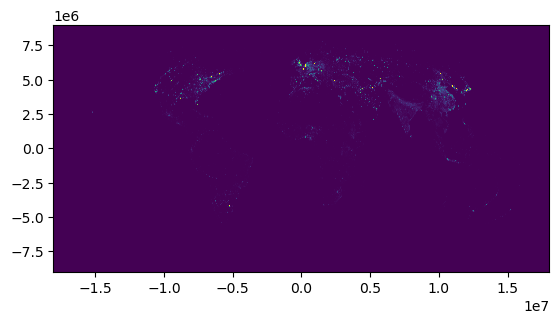

<Axes: >

In [30]:
img = rasterio.open(reallocated_footprint_tif_path_compressed)
show(img, vmax = 1000)